In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,4

In [4]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [5]:
train.shape,test.shape

((87020, 51), (37717, 50))

In [6]:
target = 'Disbursed'
IDcol = 'ID'

In [8]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [33]:
# test_results = pd.read_csv('test_results.csv)
def modelfit(model, dtrain, dtest, predictors, useTrainCV=True,
            cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgb_train = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgb_test = xgb.DMatrix(dtest[predictors].values)
        cv_result = xgb.cv(xgb_param, xgb_train, 
                           num_boost_round=model.get_params()['n_estimators'],
                          nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cv_result.shape[0])
        
        model.fit(dtrain[predictors],dtrain['Disbursed'], eval_metric='auc')
        
        dtrain_pred = model.predict(dtrain[predictors])
        dtrain_predprob = model.predict_proba(dtrain[predictors])[:,1]
        
        print('\nAbout this model:')
        print('Acc : %.4g' % metrics.accuracy_score(dtrain['Disbursed'].values,dtrain_pred))
        print(dtrain['Disbursed'].shape,dtrain_predprob.shape)
        print('AUC score on test: %f' % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
              
        feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


About this model:
Acc : 0.9854
(87020,) (87020,)
AUC score on test: 0.830662


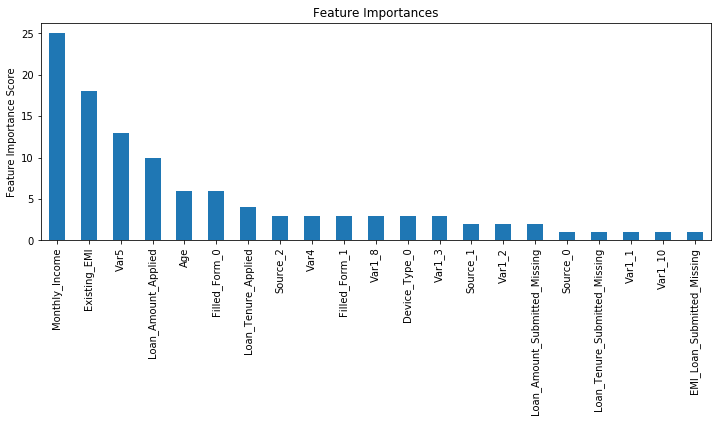

In [34]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

In [35]:
#对subsample 和 max_features 用grid search查找最好的参数
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [36]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83764, std: 0.00875, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83837, std: 0.00825, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83716, std: 0.00818, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84016, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83965, std: 0.00537, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.83935, std: 0.00548, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83570, std: 0.00587, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83448, std: 0.00726, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83456, std: 0.00554, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82851, std: 0.00651, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82955, std: 0.00580, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83158, std: 0.00677, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1


About this model:
Acc : 0.9854
(87020,) (87020,)
AUC score on test: 0.788163


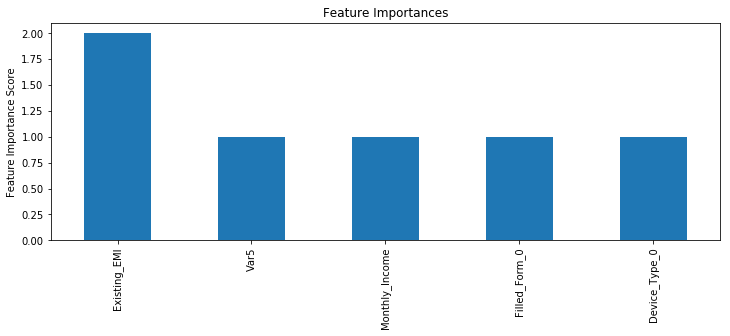

In [40]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, train, test, predictors)